In [1]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import clone

# Обучение модели

## Вспомогательные функции

In [2]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [3]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

## Загружаем данные из pickle

In [4]:
model_file = open('processed_data.pkl', 'rb')
data = pickle.load(model_file)
model_file.close()
data

,duration,rounds,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,...,hitsTotal_difference,takedownTotal_difference,submissionAttempts_difference,takeovers_difference,hitsBodyTotal_difference,hitsLegsTotal_difference,weight_difference,height_difference,legSwing_difference,eventDate
id,,,,,,,,,,,,,,,,,,,,,
5201,104.0,1.0,27.0,34.0,0,0,0,0,0,0,...,4.0,3.0,1.0,0.0,0.0,1.0,-18.6,-10.2,0.0,1993-11-12 00:00:00
5202,52.0,1.0,24.0,23.0,0,1,0,0,1,0,...,2.0,2.0,1.0,0.0,0.0,0.0,2.3,-7.6,0.0,1993-11-12 00:00:00
5203,59.0,1.0,23.0,34.0,0,1,0,0,0,0,...,-14.0,0.0,0.0,0.0,0.0,-2.0,26.8,-2.5,0.0,1993-11-12 00:00:00
5204,57.0,1.0,29.0,27.0,0,1,0,0,0,0,...,-12.0,0.0,-1.0,-1.0,0.0,0.0,13.6,0.0,0.0,1993-11-12 00:00:00
5205,138.0,1.0,27.0,30.0,0,0,0,0,1,0,...,7.0,1.0,0.0,0.0,0.0,2.0,-9.5,0.0,0.0,1993-11-12 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,260.0,1.0,25.0,25.0,0,1,0,0,1,1,...,19.0,1.0,1.0,0.0,0.0,0.0,0.0,7.6,5.1,2019-12-08 05:00:00
6338,300.0,3.0,30.0,22.0,0,1,0,0,0,0,...,71.0,1.0,0.0,0.0,1.0,-2.0,0.0,-5.1,-7.6,2019-12-08 05:00:00
5311,300.0,5.0,31.0,35.0,0,0,0,0,0,0,...,6.0,2.0,-1.0,0.0,2.0,1.0,0.0,-2.5,0.0,2019-12-14 00:00:00


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6257 entries, 5201 to 6340
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   duration                        6257 non-null   float64       
 1   rounds                          6257 non-null   float64       
 2   f1_age                          6257 non-null   float64       
 3   f2_age                          6257 non-null   float64       
 4   f1_isHomeCity                   6257 non-null   int64         
 5   f1_isHomeCountry                6257 non-null   int64         
 6   f1_isHomeTimezone               6257 non-null   int64         
 7   f2_isHomeCity                   6257 non-null   int64         
 8   f2_isHomeCountry                6257 non-null   int64         
 9   f2_isHomeTimezone               6257 non-null   int64         
 10  winner                          6257 non-null   bool          
 11  K

## Выбираем независимые и целевую переменные

### Выбираем период для обучающей и тестовой выборки 

In [6]:
def X_y_split(df , feature_names, target_column, basline_column):
    """
  Функция разделяет выборку на трейн , тест и выделяет бейслайн
  На входе pandas dataframe и перечень фичей для обучения/ целевая переменная/ бейслайн фича,
  На выходе train/test X, Y, baseline dataframes
  """
    X = df[feature_names]
    Y= df[target_column]
    Y_baseline = df[basline_column]
    X_train, X_test, Y_train, Y_test = X.iloc[0:-100,:], X.iloc[-100:], Y.iloc[0:-100], Y.iloc[-100:] #В качестве тестового множества берем последние 100 дней
    Y_train_baseline , Y_test_baseline = Y_baseline[0:-100],  Y_baseline[-100:]
    return X, Y, Y_baseline, X_train, X_test, Y_train, Y_test,  Y_train_baseline , Y_test_baseline

In [7]:
X = data.drop(columns=['winner'])
y = data[['winner', 'eventDate']]
X_train = X[X['eventDate'].dt.year < 2018].drop(columns=['eventDate'])
X_test = X[X['eventDate'].dt.year >= 2018].drop(columns=['eventDate'])
y_with_date_to_train = y[y['eventDate'].dt.year < 2018]
y_with_date_to_test = y[y['eventDate'].dt.year >= 2018]

In [8]:
y_train = y_with_date_to_train['winner']
y_test = y_with_date_to_test['winner']

## Пробуем случайный лес

In [9]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train.values)

y_pred_rfc = rfc.predict(X_test)

### F1_score метрика

In [10]:
f1_score(y_test, y_pred_rfc)

0.7773584905660378

### Матрица ошибок и метрика accuracy

Accuracy RandomForest:  0.7389380530973452


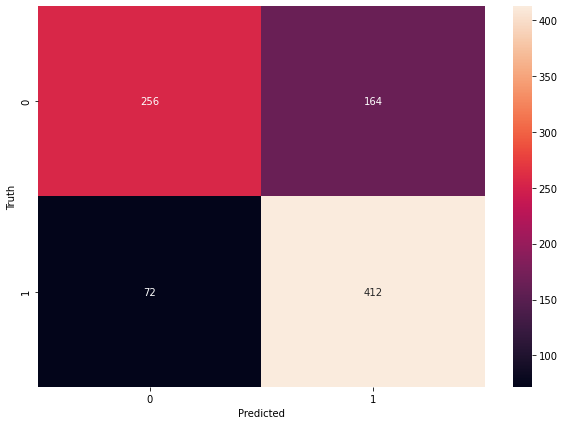

In [11]:
plt.figure(figsize=(10,7))
cmd_forest = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(cmd_forest ,annot=True , fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print('Accuracy RandomForest: ', rfc.score(X_test, y_test))

## Стекинг

In [12]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1),
], X_train.values, X_test.values, y_train.values, cv)

100%|██████████| 2/2 [00:26<00:00, 13.44s/it]


In [13]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
y_pred_clf = clf.predict(stacked_features_test)

In [14]:
f1_score(y_test, y_pred_clf)

0.7702205882352942

In [15]:
accuracy_score(y_test, y_pred_clf)

0.7234513274336283

In [16]:
stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    RandomForestClassifier(n_estimators=300, n_jobs=-1),
], X_train.values, X_test.values, y_train.values, cv)

100%|██████████| 2/2 [00:27<00:00, 13.64s/it]


In [17]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
y_pred_clf = clf.predict(stacked_features_test)

In [18]:
f1_score(y_test, y_pred_clf)

0.779467680608365

In [19]:
accuracy_score(y_test, y_pred_clf)

0.7433628318584071

### Стекинг с нормализацией данных

In [20]:
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(X_train)
cover_X_test = scaler.transform(X_test)

In [21]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1),
], cover_X_train, cover_X_test, y_train.values, cv)

100%|██████████| 2/2 [01:02<00:00, 31.38s/it]


In [22]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
y_pred_clf = clf.predict(stacked_features_test)

In [23]:
f1_score(y_test, y_pred_clf)

0.7723502304147466

In [24]:
accuracy_score(y_test, y_pred_clf)

0.7267699115044248

## Пробуем XGboost classifier

In [25]:
import xgboost as xgb

### Преобразовываем независимые и целевую переменные

In [26]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

### Настраиваем дефолтные параметры

In [27]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

### Обучаем модель XGBoost Classifier

In [28]:
xgb_model = xgb.train(param, D_train, steps)

### Предсказываем целевую переменную

In [29]:
preds = xgb_model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Accuracy = 0.7389380530973452


In [30]:
# Мы пытались
# plt.figure(figsize=(10,7))
# cmd_xgb = confusion_matrix(D_train, D_test)
# sns.heatmap(cmd_xgb, annot=True, fmt='d')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# print('Accuracy XGBClassifier: ', cmd_xgb.score(D_train, y_test))

# Всем спасибо, все идем спать!